In [1]:
#%%javascript
#IPython.load_extensions('calico-spell-check')

#Machine Learning: Identifying Fraud From Enron Email   
###Zach Farmer   
####Udacity Data Analyst Nano Degree Project  5

##Table of Contents     
* [Project Overview](#Project Overview)   
* [Question Overview](#Questions)       
* [Necessary Resources](#Necessary Resources)      
* [Project Goal](#Project Goal) 
   * [Question 1--Part 1](#Question 1--Part 1)          
* [Analysis](#Analysis)  
   * [Question 1--Part 2](#Question 1--Part 2)     
   * [original poi_id.py](#original poi_id.py) 
   * [First Look](#First Look)  
   * [Preprocessing / Feature Selection / Feature Creation](#Preprocessing / Feature Selection / Feature Creation)   
   * [Question 2](#Question 2)    
   * [Question 3](#Question 3)     
   * [Algorithm Choice](#Algorithm choice)   
   * [Question 4](#Question 4)     
   * [Question 5](#Question 5)     
   * [Question 6](#Question 6)    
   * [POI Script](#POI Script)  
   * [Test Classifier](#Test Classifier) 
* [References and Resources](#References and Resources)      


<a id="Project Overview"></a>   
****   

##Project Overview

*"In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity."*    

> The above project overview is from Udacity's Project 5 Details. It can be found [here](https://www.udacity.com/course/viewer#!/c-nd002/l-3174288624/m-3180398637 "https://www.udacity.com/course/viewer#!/c-nd002/l-3174288624/m-3180398637")     

<a id="Questions"></a>      
****   

##Question Overview        
*1. Summarize for us the goal of this project and how machine learning is useful in trying to accomplish it. As part of your answer, give some background on the dataset and how it can be used to answer the project question. Were there any outliers in the data when you got it, and how did you handle those?*         
*2. What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? Give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.*             
*3. What algorithm did you end up using? What other one(s) did you try? How did model performance differ between algorithms?*            
*4. What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well?  How did you tune the parameters of your particular algorithm?*     
*5. What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?*      
*6. Give at least 2 evaluation metrics and your average performance for each of them.  Explain an interpretation of your metrics that says something human-understandable about your algorithms' performance.*   

> Note: These question are answered throughout the this notebook at points where my analysis and code address their concerns. However in order to provide a clean and single location for easier review of all of the questions and their respective answer will be saved to a separate markdown file contained in the local directory named "Question.md". 

<a id="Necessary Resources"></a>  
*******   

##Necessary Resources       
In the local directory are the original skeleton files and emails by address as provided by Udacity for the project. All relevant files will be loaded into this notebook and the project conducted herein. The following project has been deconstructed into its constituent parts. The final `poi_id.py` file will be included near the end of the report in its entirety. In order to document my thinking and to incorporate the answers to the provided questions into the flow of the report I have reproduced the different stages in the `poi_id.py` file and reviewed them in their own sections. My methods of feature selection and classifier selection implemented a pipeline with a grid-search through the hyper parameters of my feature selection and classifier algorithm parameters. Therefore when exploring the different sections individually such as the feature selection understand that the parameters I chose to use were derived from the grid-search performed to find the best overall classifier. 

This project borrows heavily from Sklearn's machine learning modules, as a result you will need to install these modules in order to run the project on your machine. Constituent to the sklearn requirements you will need to implement numpy structures and therefore need the numpy module. I found that installing the anaconda python distribution satisfied all the requirements necessary to run everything in this notebook. You will need to ensure a Scikit-Learn distro. of at least version 0.17 or higher as some of the functions used are not present in older versions or are implemented in a significantly different manner. There is one script contain in this report that has been configured to run using `IPython.parallel`. This script, to run effectively, requires that you activate more clusters for your notebook to access. In order to practice using large distributed resource I used MIT's [starcluster](http://star.mit.edu/cluster/docs/latest/index.html# "http://star.mit.edu/cluster/docs/latest/index.html#") and moved the relevant script to an AWS EC2 cluster with many cores to distribute the embarrassingly parallel grid-search computations over. 

`poi_id.py` : *Starter code for the POI identifier* 

`final_project_dataset.pkl` : *The dataset for the project, more details below.* 

`tester.py` : *code to test results* 

`emails_by_address` : *this directory contains many text files, each of which contains all the messages to or from a particular email address, It is for reference.*    

`poi_names.txt` : *hand coded person of interest ground truth values. A list of the real poi's and non poi's hand coded and provided by Udacity.*   

`enron61702insiderpay.pdf`: *financial data in pdf format, used for description of the financial features.* 

`tools/`: *directory containing supplemental modules written by Udacity instructors. Necessary for testing script and general feature extraction.* 

> *"As preprocessing to this project, we've combined the Enron email and financial data into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels."*  

**Final_Project_dataset:** details follow 

**financial features:** ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)

**email features:** ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'poi', 'shared_receipt_with_poi'] (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)_

**POI label**: [‘poi’] (boolean, represented as integer)   


<a id="Project Goal"></a>    
***** 

##Project Goal   

<a id="Question 1--Part 1"></a>     

###Question 1 - Part 1:
***Summarize the goal of this project and how machine learning is useful in trying to accomplish it. As part of the answer, give some background on the dataset and how it can be used to answer the project question.***     

***Answer:*** 

The fundamental goal of this project is to determine whether or not an Enron employee is a person of interest (___POI___<font color="red" size = 3>*</font>) in the massive fraud perpetrated by the corporation. We will use a machine learning classifier taking as input a series of features and outputting a prediction as to whether a person is a POI or not. The series of input features will be made up of the massive court mandated release of Enron's data, from financial data to email messages.  
> *"This dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages. This data was originally made public, and posted to the web, by the Federal Energy Regulatory Commission during its investigation."* [Enron Email Dataset](https://www.cs.cmu.edu/~./enron/ "https://www.cs.cmu.edu/~./enron/")       

The financial data was collected for the employees in the email corpus and mapped to the relevant people by Udacity Instructors.

By treating each of those features gathered from the above resources as vectors containing underlying information regarding possible fraud we can mathematically work towards constructing a model to predict behavior that is possibly fraudulent. By these means if an effective model can be found we should be able to simply plug in the inputs (features) of an employee and be told with hopefully high accuracy whether that employee was likely engaged in fraudulent behavior. Remember that in our case we are simply deciding whether or not an employee should be given extra scrutiny (i.e. person of interest).   

> <font color="red", size = 2>*What is a person of interest: Indicted, Settled without admitting guilt, Testified in exchange for immunity*</font> 

<a id="Analysis"></a>     
****  

##Analysis

In [2]:
##Modules used in the project 
import sys # for path changes to supplemental code
import pickle # neccessary to save final python objects
import time # for measure length of algorithms
import numpy as np # for sklearn algorithms
import pandas as pd # for data analysis 
import matplotlib as plt # for plotting  

import re # grep 
import os # path navigation
import pprint # used mainly for my analysis 

sys.path.append("tools/")
from feature_format import featureFormat, targetFeatureSplit  
from tester import dump_classifier_and_data   

## Following modules are loaded where relevant
# from pandas.tools.plotting import scatter_matrix #data visualization

## Preprocessing and validation 
# from sklearn.feature_selection import SelectPercentile, f_classif # feature selection
# from sklearn.decomposition import PCA # features selection and transformation
# from sklearn.preprocessing import MinMaxScaler # feature scaling
# from sklearn import cross_validation 
# from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import StratifiedShuffleSplit
# from sklearn.pipeline import Pipeline, FeatureUnion # hyper-parameter optimization
# from sklearn.grid_search import GridSearchCV # hyper-parameter optimization

## Classifier models training
# from sklearn import svm 
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegressionCV

## Model evaluation 
# from sklearn.metrics import classification_report

# from itertools import compress # for data summary reporting

<a id="original poi_id.py"></a>
*****

###Orginal poi_id.py script

The following code is the original `poi_id.py` skeleton file for reference. The order of tasks is not strictly followed in the following analysis but all tasks are addressed.

In [3]:
# #!/usr/bin/python

# import sys
# import pickle
# sys.path.append("tools/")

# from feature_format import featureFormat, targetFeatureSplit
# from tester import dump_classifier_and_data

# ### Task 1: Select what features you'll use.
# ### features_list is a list of strings, each of which is a feature name.
# ### The first feature must be "poi".
# features_list = ['poi','salary'] # You will need to use more features

# ### Load the dictionary containing the dataset
# with open("final_project_dataset.pkl", "r") as data_file:
#     data_dict = pickle.load(data_file)

# ### Task 2: Remove outliers
# ### Task 3: Create new feature(s)
# ### Store to my_dataset for easy export below.
# my_dataset = data_dict

# ### Extract features and labels from dataset for local testing
# data = featureFormat(my_dataset, features_list, sort_keys = True)
# labels, features = targetFeatureSplit(data)

# ### Task 4: Try a varity of classifiers
# ### Please name your classifier clf for easy export below.
# ### Note that if you want to do PCA or other multi-stage operations,
# ### you'll need to use Pipelines. For more info:
# ### http://scikit-learn.org/stable/modules/pipeline.html

# # Provided to give you a starting point. Try a variety of classifiers.
# from sklearn.naive_bayes import GaussianNB
# clf = GaussianNB()

# ### Task 5: Tune your classifier to achieve better than .3 precision and recall 
# ### using our testing script. Check the tester.py script in the final project
# ### folder for details on the evaluation method, especially the test_classifier
# ### function. Because of the small size of the dataset, the script uses
# ### stratified shuffle split cross validation. For more info: 
# ### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# # Example starting point. Try investigating other evaluation techniques!
# from sklearn.cross_validation import train_test_split
# features_train, features_test, labels_train, labels_test = \
#     train_test_split(features, labels, test_size=0.3, random_state=42)

# ### Task 6: Dump your classifier, dataset, and features_list so anyone can
# ### check your results. You do not need to change anything below, but make sure
# ### that the version of poi_id.py that you submit can be run on its own and
# ### generates the necessary .pkl files for validating your results.

# dump_classifier_and_data(clf, my_dataset, features_list)
 



<a id="First Look"></a>

###First look at the data set

In [4]:
#!/anaconda/bin/python 
#Author: Zach Farmer
#Purpose: first look at Enron dataset
"""
    The following code block is a first look analysis of all of 
    the data contained within the data_dict provided by Udacity 
    in the final_project_dataset.pkl file.  
""" 

def data_dict_to_pd_df(data_dictionary):
    """
        Convert data_dict into a pandas dataframe for easier analysis and plotting
        
        Paramters: 
            data_dictionary = dictionary of dataset 
            (data_dict provided by Udacity) to be converted 
            into a pandas data frame
    
        Output: 
            two dataframes: one to include the full set of data, the 
        second to contain just the poi's.
    """

    # Convert dictionary into pandas dataframe for easier 
    # analysis of values: missing, outlier, etc. 
    enron_df = pd.DataFrame.from_dict(data_dict).T 
    
    # create seperate data frame of just the poi's
    poi_df = enron_df[enron_df.poi==1]
    
    return (enron_df, poi_df) 

def data_set_overview(values):
    """
        Print out overview statistics 
        
        Parameters: 
            values = Values for the keys (data points, persons's)
            in the dataset dictionary (data_dict)
    
        Output: 
            Big picture overview of the data set. To include
        total number of data points. Total number of features and 
        total number of persons of interest.
    """
    print "Number of data points in the data_dict (people): {0}\n".\
    format(len(data_dict.items()))   
    print "Number of Features (excluding email content): {0}\n".\
    format(len(set(values)))
    print "Number of Persons of Interest in data_dict: {0}\n".\
    format(sum([person['poi'] == 1 for person in data_dict.values()]))

    return None 

def num_NaNs(enron_df, poi_df):
    """
        find number of missing values for each feature
        
        Parameters: 
            enron_df = full Enron dataframe 
            poi_df = subsetted POI Dataframe 
    
        Ouput: 
            Data Frame containing count and percentage of 
        NaN's by feature for both data frames
    """
    
    Num_NaNs_full = enron_df.apply(lambda x: x == 'NaN', axis=0).sum()
    Per_Nans_full = enron_df.apply(lambda x: x == 'NaN', axis=0).\
           sum()/float(len(data_dict.items()))*100
    Num_NaNs_poi = poi_df.apply(lambda x: x == 'NaN', axis=0).sum()
    Per_NaNs_poi = poi_df.apply(lambda x: x == 'NaN', axis=0).\
           sum()/float(len(poi_df))*100
    Num_NaNs_noPoi = enron_df[enron_df['poi'] == 0].\
    apply(lambda x: x == 'NaN', axis=0).sum()
    Per_NaNs_noPoi = enron_df[enron_df['poi'] == 0].\
    apply(lambda x: x == 'NaN', axis=0).\
           sum()/float(len(enron_df[enron_df['poi'] == 0]))*100
        
    NaN_df = pd.concat([Num_NaNs_full, Per_Nans_full, Num_NaNs_poi, Per_NaNs_poi,
                        Num_NaNs_noPoi, Per_NaNs_noPoi], axis=1)
    NaN_df.columns = ["Num. Full","Precent Full","Num. Poi","Percent Poi","Num. noPoi","Percent noPoi",
                      ]
    
    return NaN_df

if __name__ == "__main__":
    ### Load the dictionary containing the dataset
    with open("final_project_dataset.pkl", "r") as data_file:
        data_dict = pickle.load(data_file)
    
    ## Find total number of uniques features for the financial data
    features = [value for value in data_dict.itervalues() for value in value.keys()]
    
    ## Overview of data set
    data_set_overview(features)
    
    ## Find total number of POI's from provided txt file
    c = !awk '{for(i=1;i<=NF;i++){if($i~/^\(/){print $i}}}' poi_names.txt | wc -l
    print "Number of POIs as identified by Udacity staff and listed in\
 the poi_name.txt file: {0}\n".format(c[0].strip())
    
    ## convert to pandas data frames
    enron_df, poi_df = data_dict_to_pd_df(data_dict)
    
    ## Number of NaN values for each of the features
    print "Number and Percent of NaN's for each feature between\
the full data set,\n the dataset sans poi's and just the poi's:\n"  
    
    print num_NaNs(enron_df, poi_df)


Number of data points in the data_dict (people): 146

Number of Features (excluding email content): 21

Number of Persons of Interest in data_dict: 18

Number of POIs as identified by Udacity staff and listed in the poi_name.txt file: 35

Number and Percent of NaN's for each feature betweenthe full data set,
 the dataset sans poi's and just the poi's:

                           Num. Full  Precent Full  Num. Poi  Percent Poi  \
bonus                             64     43.835616         2    11.111111   
deferral_payments                107     73.287671        13    72.222222   
deferred_income                   97     66.438356         7    38.888889   
director_fees                    129     88.356164        18   100.000000   
email_address                     35     23.972603         0     0.000000   
exercised_stock_options           44     30.136986         6    33.333333   
expenses                          51     34.931507         0     0.000000   
from_messages                

A quick glance at the data suggests that a.) there is just not that much data with only 146 data points and that b.) for a many of those data points large portions of their features are missing values. There are a couple of instances where the poi data set has no values in some of the features. Specifically the directors fees and restricted stock deferred, it is the case that the non-poi dataset mostly contains NaN values too for these features with roughly 15% of the data points actually containing a value. If I were to manually remove features from this data set that I felt did not add much value I might consider removing these two features. One more feature that I might consider removing is the loan advance feature. These three features are universally under-represented in this dataset compared to the other features. Deferral payments are also rather sparsely populated however I would prefer a more analytical approach to determining the value of this variable.    

There are some cases where all poi's have values for certain features; email addresses,  expenses, other, total payments and total stock value. However it is also true that the majority of non-poi's also have values in these categories. Clearly if we could 
separate the classes of the data with the existence of just one feature then machine learning would not be necessary.    

The key problem with this data set is the nominal number of data points and most machine learning algorithms performance is very closer related to the quantity of data on which to train (also the quality however in our case we are more consider with quantity and lack thereof). This means that the missing values are a big deal, they can be ignored (i.e. drop those features and data points with lots of missing values). This is a questionable option when we have so few data points to begin with. We could impute the data or simply set the missing values to zero. Both of these carry some risk of inserting bias into the data and failing to capture the unique outliers in those features that we impute. These outliers are some of the very things our classification algorithm is trying to pick up on in order to predict possible fraudulent behavior. It may be best simply to ignore those features where both the poi and non-poi have mostly 'NaN' values.    

Udacity's `featureFormat` function chooses to replace all the 'NaN' values with 0.0 and then remove any data points where all of the features are 0.0 (an additional option allows you to remove a data point that contains any 0.0 valued features--to aggressive in my opinion). There are of course problems that can arise by simply assuming that a 'NaN' can be replaced with a 0.0 without consequence. However other imputation methods are especially difficult in this case as we have so little other data from which to draw inferences in order to weigh imputation methods. 


> Might have consider adding a tf-idf vectorizer for the words in the email messages, however this will create a situation where we have a much larger number of features than we do data points (not always a bad thing). In addition the following analysis shows that not all of the email address have corresponding financial data and vice versa, suggesting that we would have to introduce data points wholly missing either financial data or bag of words data.



In [5]:
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: Explore possibility of using email content in classifier
from poi_email_addresses import poiEmails

def emailFileNames(directory_of_email_files):
    """
        Find the unique email address that are apart of the to-and-from email corpus provided
        by Udacity for reference
        
        Parameters: 
            directory_of_email_files = The name (str) of the email directory containing 
        the .txt files of the to/from emails. The .txt file naming convention includes the 
        email address. (e.g. 'to_jeb.ligums@enron.com.txt','from_jeb.ligums@enron.com.txt')
    
        Output: 
            The unique email addresses found in the directory in python list format.
    """
    current_directory = os.getcwd()
    email_by_address = os.listdir(os.path.join(current_directory,directory_of_email_files))

    emails_all = [] 
    for elem in email_by_address:
        emails_all.append(elem.split("_")[1][0:-4])

    unique_emails_all = set(emails_all)
    
    return unique_emails_all

def numSharedEmails(email_list_1,email_list_2):
    """
        find the number of emails in common 
        Parameters: 
            email_list_1 = python list containing unique email addresses
            email_list_2 = python list containing unique email addresses
    
        Output: 
            Return the number of unique emails from the first list 
        that are found in the second list. 
    """
    count = 0 
    for email in email_list_1:
        if email in email_list_2:
            if email == "NAN":
                pass
            else:
                count +=1
        else:
            continue
    return count

    
if __name__ == "__main__":
    ## Generate list of emails in the data set
    emails_in_dataset = [value['email_address']  for value in data_dict.itervalues()\
                         if value['email_address'] != "NaN"]
    unique_dataset_emails = set(emails_in_dataset)
    
    poi_emails_in_dataset = [value['email_address'] for value in data_dict.itervalues()\
                             if value['poi'] == 1]
    
    ## Count the number of data points that include email addresses
    print "Number of data points (persons) in the dataset with a known email address:__{0}__".\
    format(len(unique_dataset_emails)) #Remove the NaN value
    
    ## Count the number of unique email address in the email_by_address corpus
    print "Number of unique email addresses in the emails_by_address reference corpus:__{0}__".\
    format(len(emailFileNames("emails_by_address"))-1) #Account for empty line recorded as an address 
    
    ## Count the number of unique email from the dataset that are in the email_by_address
    ## corpus
    print "Number of unique email addresses in the dataset that are found in the\nemails_by_address\
 corpus:__{0}__".format(numSharedEmails(unique_dataset_emails,unique_dataset_emails)) 
    
    ##Count the number of unique poi emails in the data dictionary found in the 
    ## email_by_address corpus
    print "Number of unique poi emails in the dataset that are found in the\nemails_by_address\
 corpus:__{0}__".format(numSharedEmails(poi_emails_in_dataset,unique_dataset_emails))
    
    ## return list from Udacity's person of interest email address function
    poi_email_address = poiEmails()

    ## Count the number of poi's email address in the email_by_address corpus
    print "Number of POI email addresses (according to poi_email_addresses):__{0}__".format(len(poi_email_address)) 
    print "Number of POI email addresses found in the emails_by_address corpus:__{0}__".\
    format(numSharedEmails(poi_email_address,unique_dataset_emails))

Number of data points (persons) in the dataset with a known email address:__111__
Number of unique email addresses in the emails_by_address reference corpus:__2328__
Number of unique email addresses in the dataset that are found in the
emails_by_address corpus:__111__
Number of unique poi emails in the dataset that are found in the
emails_by_address corpus:__18__
Number of POI email addresses (according to poi_email_addresses):__90__
Number of POI email addresses found in the emails_by_address corpus:__17__


Roughly 75% of the data points in our data_dict have email addresses. It should be noted that we have only one listed email in the dataset (data_dict) but it is certainly possible that some people may have had multiple email accounts. This means there is a chance we may fail to map all of the emails that were sent and received by an individual in our dataset to that individuals email-related features. We can find 18 of our poi's email addresses in the corpus from the dataset (this is necessarily the case given that all the unique emails in the data dictionary were found in the email corpus). Attempting to incorporate the email content as feature data into the current data dictionary would introduce a great many missing valued financial features for many of the data points if we included all of the email corpus email addresses and content. We could selectively choose to incorporate only those emails associated with addresses that have a matched pair in the data dictionary. Selectively choosing which emails to add will likely mean however that we fail to included some of the poi email addresses who we do not have financial data for and thus deprive our algorithm of valuable information about connections between poi's. This trade-off is often present in situations were we attempt to merge data from two different sources. A possible solution was addressed in the Udacity course ["Introduction to Machine Learning"](#https://www.udacity.com/course/intro-to-machine-learning--ud120 "https://www.udacity.com/course/intro-to-machine-learning--ud120") by simply recording the number of emails sent from and to a POI's (in addition to cc's) ignoring the email content, and actual addresses themselves. This meant we could capture some of the connection information without having to include all of the email addresses as data points. Of course we still have to parse over both data sets but we wouldn't be trying to directly merge them together. This solution is not the only possible one but is the method I will adopt. In terms of further study on developing a POI classifier the merging of the email content through a tf-idf vectorizer might be an interesting avenue to explore to determine if any better accuracy could be achieved in identifying POI's. To the best of my knowledge we would have to except loss of information and connections either financial related or email content related with this approach.    

                 bonus  deferral_payments  deferred_income   director_fees  \
count        82.000000          39.000000        49.000000       17.000000   
mean    2374234.609756     1642674.153846  -1140475.142857   166804.882353   
std    10713327.969046     5161929.973575   4025406.378506   319891.409747   
min       70000.000000     -102500.000000 -27992891.000000     3285.000000   
25%      431250.000000       81573.000000   -694862.000000    98784.000000   
50%      769375.000000      227449.000000   -159792.000000   108579.000000   
75%     1200000.000000     1002671.500000    -38346.000000   113784.000000   
max    97343619.000000    32083396.000000      -833.000000  1398517.000000   

       exercised_stock_options        expenses  from_messages  \
count             1.020000e+02       95.000000      86.000000   
mean              5.987054e+06   108728.915789     608.790698   
std               3.106201e+07   533534.814109    1841.033949   
min               3.285000e+03      1

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1078fdcd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x108609f50>]], dtype=object)

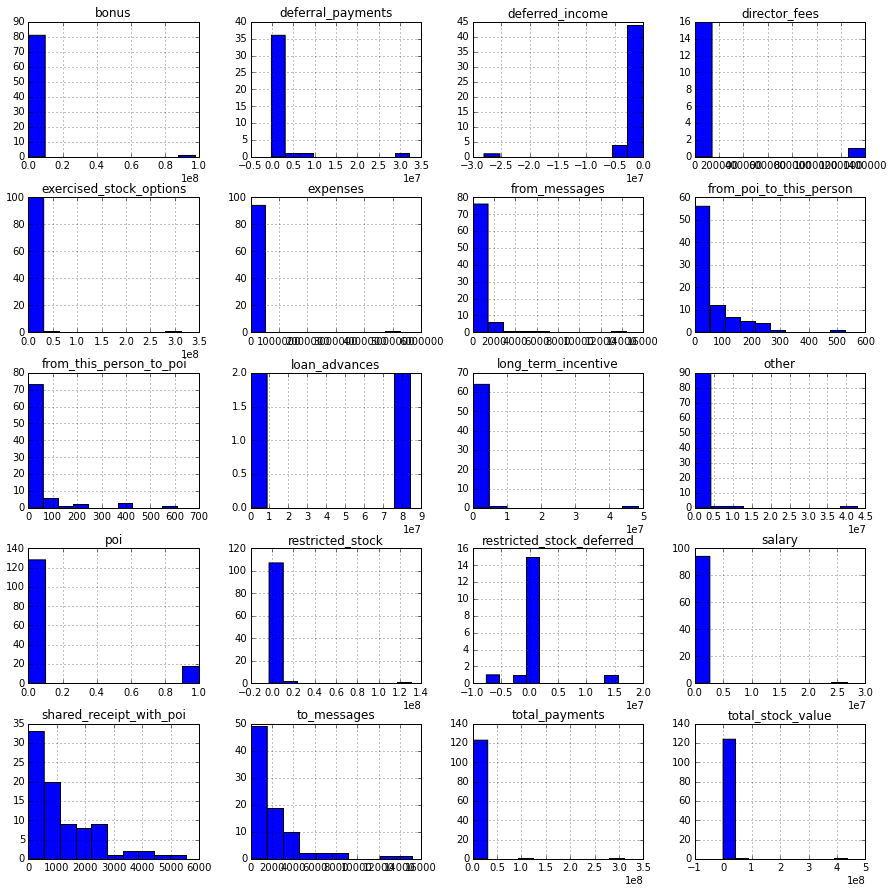

In [6]:
%matplotlib inline
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: summarize and  graph the datapoints features
"""
    Following code is for the purpose of describing the features and plotting each
    as a histogram. Hopefully will help to highlight outliers.
"""
## Convert to pandas dataframe to take advantage of internal plotting methods
enron_df = enron_df.convert_objects(convert_numeric=True)
enron_df_clnd = enron_df.loc[:,enron_df.columns != 'email_address']

print enron_df_clnd.describe()
enron_df_clnd.hist(figsize = (15,15))

Reviewing the summary statistics of our features and looking over the histograms plot there are several features that might bear a second look at. Udacity's Intro to Machine Learning specifically the lesson on outliers highlighted the 'salary' features as having possible outliers. There are a series of other features with very large difference between the I.Q.R. (Inter-Quartile-Range) and min and max values. Examples include; deferred income, bonus, deferral payments, directors fees, exercised stock options, expenses, from messages, long term incentives and a few others. While in may simply be the case that these feature contain legitimate outliers (i.e. CEO, CFO ) experience with the 'salary' feature in the course suggests taking a look at these values further.        

The key associated with the max salary value is: ['TOTAL']
The data set descibed after removing the ['TOTAL'] value
                bonus  deferral_payments  deferred_income  director_fees  \
count       81.000000          38.000000        48.000000      16.000000   
mean   1201773.074074      841602.526316   -581049.812500   89822.875000   
std    1441679.438330     1289322.626180    942076.402972   41112.700735   
min      70000.000000     -102500.000000  -3504386.000000    3285.000000   
25%     425000.000000       79644.500000   -611209.250000   83674.500000   
50%     750000.000000      221063.500000   -151927.000000  106164.500000   
75%    1200000.000000      867211.250000    -37926.000000  112815.000000   
max    8000000.000000     6426990.000000      -833.000000  137864.000000   

       exercised_stock_options       expenses  from_messages  \
count               101.000000      94.000000      86.000000   
mean            2959559.257426   54192.010638     608.790698   
std    

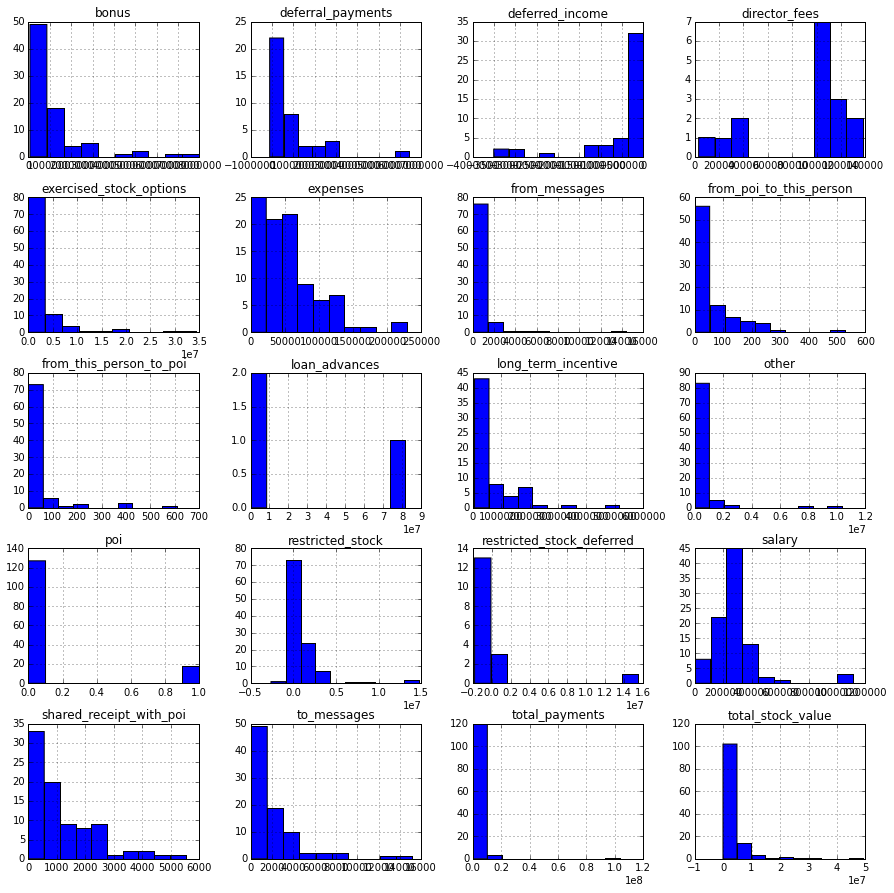

In [7]:
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: Remove Outliers from the data   
"""
    Following code first finds and removes the oultier in the converted dataframe.
    A description of the data along with histograms are plotted after the outlier 
    removal to measure the effect. Second the offending outliers are removed from 
    the data_dict.
"""

def findOutlierInFeature(data_dict, feature_name, threshold):
    """
        Find any 'outliers' in a feature by manually setting threshold value
        
        Parameters:
            data_dict = The Udacity provided data set in data_dict.
            feature_name = the name of the feature which we wish to find 
            outliers in.
            threshold = The value that we will threshold an outlier by. (e.g.
            greater than 20,000,000 is an outlier)
        
        Output:
            Print to console the key associated with the value above the 
            given threshold for the given feature.
    """  
    max_value_key = [peeps for peeps, value in data_dict.items()\
                    if (value[feature_name] != 'NaN') and (value[feature_name] > threshold)]
    
    return feature_name,max_value_key
    
def removeOutliers(data_dict, data_point_name):
    """
        remove the data points associated with any discovered outliers
        
        Parameters:
            data_dict = The Udacity provided data set data_dict.
            data_point_name = The key name for the datapoint containing
            outliers. (e.g. 'Total'). 
        Output:
            data_dict with the provided data point removed from the 
            dictionary.
    """
    try:
        data_dict.pop('TOTAL',0)
        return data_dict
    except ValueError:
        print "data_point not found in data_dict."
        pass 
    
    return None
    
if __name__ == "__main__":
    ## Find outliers
    feature_name,max_value_key = findOutlierInFeature(data_dict,\
                                          feature_name = 'salary',\
                                          threshold = 20000000) 
    
    print "The key associated with the max {0} value is: {1}".\
    format(feature_name,max_value_key)
    
    ## Remove the outlier from the enron_df and analyze results
    try:
        enron_df_clnd = enron_df_clnd.drop('TOTAL', axis=0)
    except ValueError:
        pass 

    print "The data set descibed after removing the {0} value\n".\
    format(max_value_key),enron_df_clnd.describe()

    enron_df_clnd.hist(figsize = (15,15))

    ## Remove the outliers from the data_dict
    data_dict = removeOutliers(data_dict, max_value_key) 


It looks like that after removing the 'TOTAL' data point which clearly is not an actual person we have gone a long way towards reducing some of the extreme values in the features. Testing of several of the remaining features with large differences between their $75^{th}$ percentile and max values suggest other possible outliers.  

The key(s) associated with the max from_messages value is: ['KAMINSKI WINCENTY J']
The number of from messages from ['KAMINSKI WINCENTY J']: 14368
The number of all other from messages total: 37988


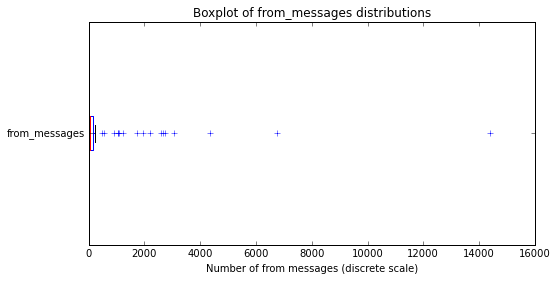

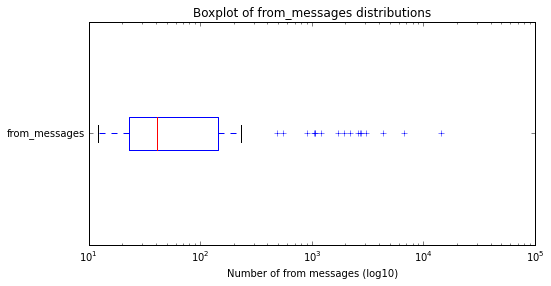

In [8]:
import matplotlib.pyplot as plt

feature_name,max_value_key = findOutlierInFeature(data_dict, 
                                                  feature_name = "from_messages",
                                                  threshold =  10000)

print "The key(s) associated with the max {0} value is: {1}".\
    format(feature_name,max_value_key)
    
msgs_by_Kaminski = data_dict['KAMINSKI WINCENTY J']['from_messages']
msgs_by_all_others = sum([value['from_messages']  for value in data_dict.itervalues()\
                         if value['from_messages'] != "NaN"])

print "The number of from messages from {0}: {1}\nThe number of all other from messages total\
: {2}".format(max_value_key, msgs_by_Kaminski, msgs_by_all_others - msgs_by_Kaminski)

#print data_dict['KAMINSKI WINCENTY J']
enron_df_clnd['from_messages'].plot(kind = 'box', figsize = (8,4),vert=False )
plt.title("Boxplot of from_messages distributions")
plt.xlabel("Number of from messages (discrete scale)")
plt.show()
#ax.set_xscale('log)
## Method for loag transform found here: 
#http://stackoverflow.com/questions/29930340/want-to-plot-pandas-dataframe-as-multiple-histograms-with-log10-scale-x-axis
# by unutbu
axs = enron_df_clnd['from_messages'].plot(kind = 'box', figsize = (8,4),vert=False )
axs.set_xscale('log')
plt.title("Boxplot of from_messages distributions")
plt.xlabel("Number of from messages (log10)")
plt.show()

It seems a little improbable that one person would have nearly half of all the from messages sent by the persons in this data set. Although it is hard to say whether it is just inside this data set that number of emails is an anomaly or if Kaminski would still be an outlier if we looked at all of the emails in the entire Enron email directory. I am not sure I will remove this data point precisely because we don't actually know if this value truly is anomalous or if it is just extreme for the data points we have financial for. There are 14,368 entries in Mr. Kaminskis from_vince.kaminski@enron.com.txt document, so I will operate under the assumption that this value although extreme is accurate.   

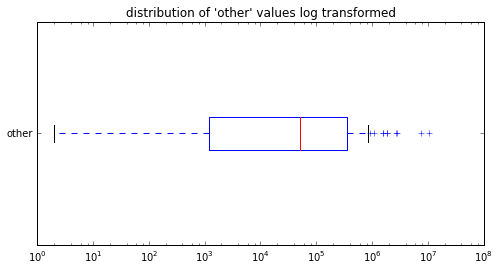

In [9]:
axs = enron_df_clnd['other'].plot(kind = 'box', figsize = (8,4),vert=False )
axs.set_xscale('log')
plt.title("distribution of 'other' values log transformed")

In [10]:
feature_name,max_value_key = findOutlierInFeature(data_dict, feature_name = "other",
                               threshold =  1000000)

print "The key(s) associated with the max {0} value is: {1}".\
    format(feature_name,sorted(max_value_key))

The key(s) associated with the max other value is: ['BAXTER JOHN C', 'FREVERT MARK A', 'IZZO LAWRENCE L', 'LAY KENNETH L', 'MARTIN AMANDA K', 'PAI LOU L', 'SHELBY REX', 'SHERRIFF JOHN R', 'WHITE JR THOMAS E']


We might expect Mr. Lay to have a rather large value and in fact we know he was very involved in fraud and therefore certainly would not want to remove this data point. The rest of the individuals are not the far outside the norm and double checking the Enron insider pay .pdf suggests their values are accurate.   

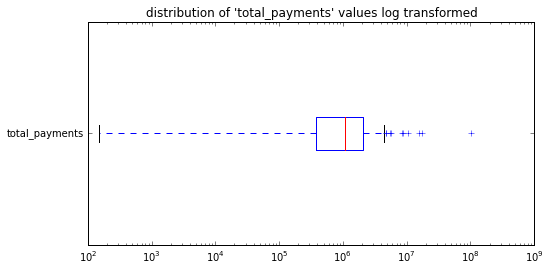

In [11]:
axs = enron_df_clnd['total_payments'].plot(kind = 'box', figsize = (8,4),vert=False )
axs.set_xscale('log')
plt.title("distribution of 'total_payments' values log transformed")

In [12]:
feature_name,max_value_key = findOutlierInFeature(data_dict, 
                                                  feature_name = "total_payments",
                                                  threshold =  10000000)

print "The key(s) associated with the max {0} value is: {1}".\
    format(feature_name,max_value_key)
    
print "Bhatnagar Sanjay's financial data:\n", pprint.pprint(data_dict['BHATNAGAR SANJAY'])

The key(s) associated with the max total_payments value is: ['LAVORATO JOHN J', 'LAY KENNETH L', 'BHATNAGAR SANJAY', 'FREVERT MARK A']
Bhatnagar Sanjay's financial data:
{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 137864,
 'email_address': 'sanjay.bhatnagar@enron.com',
 'exercised_stock_options': 2604490,
 'expenses': 'NaN',
 'from_messages': 29,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 137864,
 'poi': False,
 'restricted_stock': -2604490,
 'restricted_stock_deferred': 15456290,
 'salary': 'NaN',
 'shared_receipt_with_poi': 463,
 'to_messages': 523,
 'total_payments': 15456290,
 'total_stock_value': 'NaN'}
None


According to the `enron61702insiderpay.pdf` document Sanjay's total_payments are actually \$137,864, he's restricted stock is \$2,604,490 and his restricted stock deferred is \$-2,604,490. He's 'expenses' and 'other' are also switched around, he's exercised stock options should be \$15,456,290 and the total stock value is the same (\$15,456,290) 

In [13]:
## Correct the mistake found in the data dictionary   
data_dict['BHATNAGAR SANJAY']['total_payments'] = 137864
data_dict['BHATNAGAR SANJAY']['restricted_stock'] = 2604490
data_dict['BHATNAGAR SANJAY']['restricted_stock_deferred'] = -2604490
data_dict['BHATNAGAR SANJAY']['expenses'] = 137864
data_dict['BHATNAGAR SANJAY']['other'] = 'NaN'
data_dict['BHATNAGAR SANJAY']['exercised_stock_options'] = 15456290
data_dict['BHATNAGAR SANJAY']['total_stock_value'] = 15456290

In [14]:
print "Bhatnagar Sanjay's financial data:\n", pprint.pprint(data_dict['BHATNAGAR SANJAY'])

Bhatnagar Sanjay's financial data:
{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 137864,
 'email_address': 'sanjay.bhatnagar@enron.com',
 'exercised_stock_options': 15456290,
 'expenses': 137864,
 'from_messages': 29,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 'NaN',
 'poi': False,
 'restricted_stock': 2604490,
 'restricted_stock_deferred': -2604490,
 'salary': 'NaN',
 'shared_receipt_with_poi': 463,
 'to_messages': 523,
 'total_payments': 137864,
 'total_stock_value': 15456290}
None


In [15]:
## Ensure the extreme values in the restricted stock deferred is supported by the .pdf
min_value_key = [peeps for peeps, value in data_dict.items()\
                    if (value['restricted_stock_deferred'] != 'NaN') and (value['restricted_stock_deferred'] < -1000000)]

print "The key(s) associated with the min {0} value is: {1}".\
    format('restricted_stock_deferred',max_value_key)

The key(s) associated with the min restricted_stock_deferred value is: ['LAVORATO JOHN J', 'LAY KENNETH L', 'BHATNAGAR SANJAY', 'FREVERT MARK A']


<a id="Question 1--Part 2"></a>     

###Question 1--Part 2:          
***Were there any outliers in the data when you got it, and how did you handle those?***    
***Answer:*** Yes there was at least one major outlier that perpetuated itself throughout the financial data. This outlier was a data point labeled "TOTAL" that upon examination of the financial data .pdf clearly represented the 'Totals' of the financial features. Clearly this data point is not a person and the information it contains already exists in each of the features by simply summing over all of their values. I chose to drop the data point itself. Further outliers may exist but may also be real data and indicative of possible fraudulent behavior. After reviewing some of the features with very large values the remaining values are not throwing any serious red flags as the 'TOTAL' data point did.  

<a id="Preprocessing / Feature Selection / Feature Creation"></a>    
***

###Preprocessing -- Feature Selection -- Feature Creation        
The following code blocks will focus on the provided data_dict dataset. Some features will be dropped by hand, a few new features will be created and a final feature selection analysis will be run on the remaining features in order to reduce them based on importance. Importance was determined in a later code block in which I ran a grid search with a pipeline to find the feature selection parameters and algorithm combination to achieve the 'best' 
results from my poi classifier. The following code in designed to replicate that later 
process as closely as possible using the learned parameters and to elucidate on the results. 

The next several code blocks have been written to the local directory, I used them for my grid-search using AWS's EC2 clusters and wanted an easy way to pass these function to those remote file systems so I could reference them locally there. 

The code is located in the local directory and I simply import to the name space of the scripts where it is necessary, it exists below only as a reference for parameters. running the code would require switching the cell type to code.

In [16]:
# %%writefile create_my_dataset.py
# #!/usr/bin/python
# #Author: Zach Farmer
# #Purpose: Create my own dataset from provided data_dict 
# """
#     Functions for creating my own dataset from the provided data_dict.
    
#     Function for dropping features by hand, chiefly for the 
#     removal of the non-numeric feature 'email_address'. One could 
#     certainly manually remove other variables to perform feature selection
#     It is recommended that a more analytical approach be taken using sklearn's
#     feature selection methods. 

#     Function for computing fraction between two features provided. For the purpose
#     of creating new features based on ratios. 
    
#     Function for generating new features provided. This function implements hard 
#     coded features. It is not abstractable for the creation of any other features 
#     as written.  
# """   

# def dropFeatures(features, remove_list):
#     """
#         Parameters: 
#             features = Python list of unique features in the data_dict. 
#             remove_list = Python list of features to be removed.(drop 
#             non-numeric features such as the email address) 
    
#         Output: 
#             Python list of unique features sans the features in the remove
#             list. 
#     """   
#     ## Method courtesy of user: Donut at: 
#     ## http://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
#     features_remove = remove_list
#     learning_features = [feature for feature in features if feature not in features_remove]
    
#     return learning_features

# ## Following code adapted from Udacity's Intro to Machine learning lesson 11 Visualizing
# ## Your New Feature Quiz
# def computeFraction(feature_1, feature_2 ):
#     """ 
#         Parameters: 
#             Two numeric feature vectors for which we want to compute a ratio
#             between
     
#         Output: 
#             Return fraction or ratio of feature_1 divided by feature_2
#     """
    
#     fraction = 0.
    
#     if feature_1 == "NaN":  
#         fraction = 0.0
#     elif feature_2 == "NaN":
#         fraction = 0.0
#     else: 
#         fraction = int(feature_1) / float(feature_2)

#     return fraction
     
# def newFeatures(data_dict):
#     """
#         Parameters: 
#             data_dict provided by Udacity instructors   
    
#         Output: 
#             data_dict with new features (hard-coded)
#     """
#     ## following is not extensible or abstractable to making any other features 
#     ## then what is hard coded below.
#     for name in data_dict:

#         from_poi_to_this_person = data_dict[name]["from_poi_to_this_person"]
#         to_messages = data_dict[name]["to_messages"]
#         fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
        
#         data_dict[name]["fraction_from_poi"] = fraction_from_poi


#         from_this_person_to_poi = data_dict[name]["from_this_person_to_poi"]
#         from_messages = data_dict[name]["from_messages"]
#         fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    
#         data_dict[name]["fraction_to_poi"] = fraction_to_poi
        
#         salary = data_dict[name]['salary']
#         total_payments = data_dict[name]['total_payments'] 
#         salary_to_totalPayment_ratio = computeFraction(salary, total_payments)
        
#         data_dict[name]['salary_to_totalPayment_ratio'] = salary_to_totalPayment_ratio
        
#         salary = data_dict[name]['salary']
#         total_stock = data_dict[name]['total_stock_value'] 
#         salary_to_stockValue_ratio = computeFraction(salary, total_stock)
        
#         data_dict[name]['salary_to_stockValue_ratio'] = salary_to_stockValue_ratio
        
#     return data_dict   


In [17]:
# %%writefile select_features.py
# #!/python/bin/python
# #Author: Zach Farmer
# #Purpose: Feature Selection
# """
#     Following function is designed to find features that contain the greatest
#     explanation power in regards to the classification goal of identifying 
#     poi's. Function implements sklearn's SelectPercentile method and PCA methods.
#     Parameters for these two methods should be discovered using the gridsearch 
#     optimization in a later script. 
# """   

# def featureSelection(reduced_features,labels,clnd_features,percentile,n_components,results=False):
#     """
#         Parameters: 
#             reduced_features = Unique feature names in python list after dropping non-numeric
#             feaures. 
#             labels = ground truth labels for the data points.
#             clnd_features = data point features in numpy array format corresponding
#             to the labels.
#             percentile= the parameter for the SelectPercentile method;
#             between 0.0-1.0.
#             n_components = the n_components for the pca. 
#             results = False returns python list of selected features. If True
#             returns the metrics of the feature selectors (F-statistic, and p-values from
#             f_classif) and the top 'n' pca component variance measurements. 
    
#         Output: 
#            Resulting list of feature from the SelectPercentile function and the 
#            number of principle components used. If p_results = True then the 
#            statistics of the SelectPercentile method using f_classif will be printed.
#            In addition the explained variance of the top 'x' principle components will
#            also be printed.
#     """
#     from sklearn.feature_selection import SelectPercentile, f_classif
#     from sklearn.decomposition import PCA 
#     from itertools import compress
    
#     selector = SelectPercentile(f_classif, percentile=percentile)
#     selector.fit_transform(clnd_features, labels)
    
#     pca = PCA(n_components = n_components)
#     pca.fit_transform(clnd_features, labels)
    
#     if results == True:
    
#         f_stat = sorted(zip(reduced_features[1:],f_classif(clnd_features,labels)[0]),\
#                          key = lambda x: x[1], reverse=True)
        
#         p_vals = sorted(zip(reduced_features[1:],f_classif(clnd_features,labels)[1]),\
#                         key = lambda x: x[1])
  
#         expl_var = pca.explained_variance_ratio_
        
#         return f_stat,p_vals,expl_var
#     else:
#         ## return a boolean index of the retained features 
#         retained_features = selector.get_support()
        
#         ## index the original features by the boolean index of top x% features 
#         ## return a python list of the features to be used for training 
#         features_list = list(compress(reduced_features[1:],retained_features))
    
#         ## add back in the 'poi' to the first position in the final features list
#         features_list.insert(0,'poi')
        
#         return features_list


####Feature Selection

In [18]:
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: Identify information rich features 
from create_my_dataset import newFeatures, dropFeatures 
from select_features import featureSelection
"""
    This code will implement a feature selection I wrote to emulate the one ultimately
    used in the final poi_id.pc script. I used a pipeline inside a gridsearch to 
    train and test my classifier. Therefore in order to concentrate more attention on 
    just the feature selection process to answer the provided question this
    code attempts to return something very similar to the pipeline.
"""
if __name__=="__main__":
    ## Create my dataset
    my_dataset = newFeatures(data_dict) 
    
    ## Find total number of unique features in my_dataset
    features = [value for value in my_dataset.itervalues() for value in value.keys()]
    unique_features = list(set(features))
    
    ## Remove non-numeric features (email_address)
    reduced_features = dropFeatures(unique_features, ['email_address'])
    
    ## Method for moving an item in a list to a new position found at:
    ## http://stackoverflow.com/questions/3173154/move-an-item-inside-a-list
    ## posted by nngeek
    ## ensure that 'poi' is the first value in the feature list
    try:
      reduced_features.remove('poi')
      reduced_features.insert(0, 'poi')
    except ValueError:
      pass

    ### Extract features and labels from dataset for local features importance analysis
    data = featureFormat(my_dataset, reduced_features, sort_keys=True)
    
    labels, numpy_features = targetFeatureSplit(data)
    
    ## Find the top  most 'informative' features using sklearn's 
    ## f_classif as the metric and sklearn's pca method. 
    # Parameters used were found from a grid search over a pipeline
    percentile = 61
    n_components = 22
    final_feature_list = featureSelection(reduced_features,
                                          labels,
                                          numpy_features,
                                          percentile = percentile,
                                          n_components = n_components,
                                          results = False
                                          )
    
    print "\nTop {0} features explaining poi according to sklearn's\nSelect-Percentile\
 with the function f_classif:\n".\
    format(len(final_feature_list[1:]))
    pprint.pprint(final_feature_list[1:]) 
    
      



Top 14 features explaining poi according to sklearn's
Select-Percentile with the function f_classif:

['expenses',
 'deferred_income',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'shared_receipt_with_poi',
 'loan_advances',
 'other',
 'bonus',
 'total_stock_value',
 'long_term_incentive',
 'restricted_stock',
 'salary',
 'total_payments',
 'fraction_to_poi']


In [19]:
%matplotlib qt
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: Final visual review of features selected for model training
"""
    Review the features that remain after feature selection from the original data 
    dictionary. Does not inlcude the top principle components for obvious reasons.
    This visual analysis will only look at the features returned from the feature
    select.
""" 
from pandas.tools.plotting import scatter_matrix 

## Convert my_dataset into pandas dataframe for analysis
df,poi_df = data_dict_to_pd_df(my_dataset)

## Convert to numeric for plotting purposes
numeric_df = df.convert_objects(convert_numeric=True)  

## Index by only those features that we will use in our model training
model_df = numeric_df.loc[:,final_feature_list]

## print general statistics about the dataframe 
print model_df.describe() 

## Print scatter plot matrix of features -- To many variables to clearly read...won't graph
## inline. If you run this you will need to exit out of the graphic in order to continue running
## the rest of this script. If not interested in seeing the scatterplox matrix graphic then
## simply comment out the following line.
scatter_matrix(model_df, alpha = .9, figsize=(14, 14), diagonal='kde')


            poi       expenses  deferred_income  from_poi_to_this_person  \
count       145      95.000000        48.000000                86.000000   
mean   0.124138   55072.768421   -581049.812500                64.895349   
std    0.330882   46658.979762    942076.402972                86.979244   
min       False     148.000000  -3504386.000000                 0.000000   
25%           0   22614.000000   -611209.250000                10.000000   
50%           0   46950.000000   -151927.000000                35.000000   
75%           0   79952.500000    -37926.000000                72.250000   
max        True  228763.000000      -833.000000               528.000000   

       exercised_stock_options  shared_receipt_with_poi    loan_advances  \
count               101.000000                86.000000         3.000000   
mean            3086804.801980              1176.465116  27975000.000000   
std             5638086.075942              1178.317641  46382560.030684   
min        

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10bdbcbd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x122b3c510>]], dtype=object)

####Feature Scaling

In [20]:
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: Scale features for machine learning algorithms
""" 
    Following code scales features for model training as the ranges
    differ greater between features.
"""
from sklearn.preprocessing import MinMaxScaler 

if __name__ == "__main__":
    
    ### Extract features and labels from dataset for local testing
    data = featureFormat(my_dataset, final_feature_list, sort_keys = True)
    labels_final, features_final = targetFeatureSplit(data)

    ## Scale features with MinMax  
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features_final)

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


<a id="Question 2"></a>   

###Question 2:
***What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? Explain what feature you tried to make, and the rationale behind it. If you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values?***



**What features did you end up using in your POI identifier?**      

In [21]:
print "Features used in the POI identifier model from the SelectPercetile:\n", 
pprint.pprint(final_feature_list[1:]) 
print "\nIn addition I implemented a PCA on all of the features and returned the top {0}\
 components.\nThese top {0} components were combined with the top {1}% of features using\
 sklearn's\nfeature union method".format(n_components, percentile)



Features used in the POI identifier model from the SelectPercetile:
['expenses',
 'deferred_income',
 'from_poi_to_this_person',
 'exercised_stock_options',
 'shared_receipt_with_poi',
 'loan_advances',
 'other',
 'bonus',
 'total_stock_value',
 'long_term_incentive',
 'restricted_stock',
 'salary',
 'total_payments',
 'fraction_to_poi']

In addition I implemented a PCA on all of the features and returned the top 22 components.
These top 22 components were combined with the top 61% of features using sklearn's
feature union method


**what selection process did you use to pick them?**    

In [22]:
print "I used sklearn's Select-Percentile method with percentile = {0}% and sklearn's f_classif (ANOVA)\
 providing the metrics returning F-statistics and P-values.".format(percentile) 
print "For the top {0} principle components I used sklearn's PCA fit_transform.".\
format(n_components)



I used sklearn's Select-Percentile method with percentile = 61% and sklearn's f_classif (ANOVA) providing the metrics returning F-statistics and P-values.
For the top 22 principle components I used sklearn's PCA fit_transform.


**Did you have to do any scaling? Why or why not?**       
***Answer:*** Yes I implemented a MinMaxScaler. My features contain vastly different scales; from the to/from email percentages to total stock values in the tens of millions. While certain algorithms may handle such vast differences with greater ease (decision trees), In order to be as flexible as possible with my algorithm choices I scaled all of the features for my dataset.    

**Engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it.**   
***Answer:*** I felt that Katie's (Udacity Intro to Machine Learning course co-instructor) idea of generating features that measured the frequency of communications both to and from known POIs was an excellent idea. This method of utilizing the emails allows us to gather some of the information available in the email corpus without trying to engineer methods of including the actual content of the emails in the same dataset as the financial data, this spared me from the trouble of combining two different datasets, which did not contain all of the same data points. Furthermore Katie's idea of a shared receipt also resonated with me as an excellent method of capturing second degree associations with POIs. After implementing the fraction_to and fraction_from this person to POI and the shared receipt feature I engineered two other features. Salary to total payment ratio and salary to total stock value ratio. These features were engineered on the hypothesis that an individual is most likely to commit fraud because they are receiving some sort of benefit from doing so. In other words it is a risk and reward trade-off and my theory was that individuals committing fraud would show a lower ratio of salary to total compensation metrics. In other words two people in similar professional standings with fairly similar base salaries should show differences in total compensation metrics. In the case of an individual committing fraud they would be more likely to receive financial gains as a result of their fraudulently attained success in the form of some type 'bonus' compensation and therefore they should present higher total payments and total stock values and consequently a lower ratio of salary to those metrics. My engineered features did not make it past the feature selection stage, unless you count them as possibly being included in the top principle components. I believe that because many of the key individuals involved in the fraud were at the very top of the company and those individuals naturally receive total compensation far in excess of their base salaries the information I was hoping to discover in the data wasn't very distinctive.    

**In your feature selection step, if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.**    
***Answer:*** I used Sklearn's SelectPercentile method to select my features. The parameter choice of 61% for the Select-Percentile method was arrived at after running a randomized grid search over my feature selection and algorithm parameters. The combination with the best outcome was a combination of the top 61% of features and the top 22 principle components from the PCA. Technically the top 22 components are transformations of the features therefore I used 14 of the original features but all the features were used to generate the 22 principle components.  


In [23]:
from select_features import featureSelection

f_stat, p_vals, expl_var = featureSelection(reduced_features,
                                            labels,
                                            numpy_features,
                                            percentile = percentile,
                                            n_components = n_components,
                                            results = True)

print "F-statistics of sklearn's f-classif (ANOVA) for features:\n"
pprint.pprint(f_stat)
print "\nP-values of sklearn's f-classif (ANOVA) for features:\n"
pprint.pprint(p_vals)
print "\nThe variance explained by the top {0} components of the PCA:\n".format(n_components)
pprint.pprint(zip(range(1,len(expl_var)+1,1),expl_var))

F-statistics of sklearn's f-classif (ANOVA) for features:

[('total_stock_value', 22.783481328003685),
 ('exercised_stock_options', 22.610389609556254),
 ('bonus', 21.060001707536571),
 ('salary', 18.575703268041785),
 ('fraction_to_poi', 16.641707070468989),
 ('deferred_income', 11.595547659730601),
 ('long_term_incentive', 10.072454529369441),
 ('total_payments', 9.3782232542572856),
 ('restricted_stock', 8.9617839833519675),
 ('shared_receipt_with_poi', 8.7464855321290802),
 ('loan_advances', 7.2427303965360181),
 ('expenses', 5.5575259528039913),
 ('from_poi_to_this_person', 5.3449415231473374),
 ('other', 4.2198879086807812),
 ('fraction_from_poi', 3.2107619169667441),
 ('salary_to_totalPayment_ratio', 2.7730011744152532),
 ('from_this_person_to_poi', 2.4265081272428781),
 ('director_fees', 2.1076559432760908),
 ('to_messages', 1.6988243485808501),
 ('restricted_stock_deferred', 0.74349338833843037),
 ('deferral_payments', 0.2170589303395084),
 ('from_messages', 0.1641644982342873

<a id="Question 3"></a>    
***

###Question 3     
**What algorithm did you end up using? What other ones did you try? How did model performance differ between algorithms?**

<a id="Algorithm choice"></a>    

###Algorithm Choice

One of the scripts below is actually written to the local directory and although it can be run locally if we manually activate more clusters the script was designed to be exported to an AWS EC2 cluster. The final parameters and classifier were reached utilizing a different script found in this section of the report. 
All of the code implemented in this section was done in pursuit of finding the optimal hyper-parameters for both the feature selection and classifier model. The code used to find the parameters and classifier for the final classifier to be tested was performed on my local machine using a randomized grid search in order to reduce the run time. The other code was used with starcluster to instantiate and run in parallel an exhaustive grid search on an EC2 cluster and is here for reference only. It can only be run if you have an AWS account and it costs money to rent the cluster time. In addition it uses an exhaustive naive grid search which takes a long time to run even with access to many cores. I decided to implement that code just for practice. 

In [24]:
#!/anaconda/bin/python
#Author: Zach Farmer
#Purpose: Parallelize algorithm and feature selection with randomized grid search. Run on local
#Machine
"""
    The following code blocks borrower some from Olivier Grisel
    "Advanced Machine Learning with scikit-learn" tutorial given at PyCon
    2013 in Santa Clara. The tutorial provided ipython notebooks with
    examples. I also took liberal advantage of sklearn's documentation and 
    examples of pipeline usage and grid search functions. Sklearn's 
    website was far and away the most useful reference for this part of
    my analysis and much of my code is based on their examples.
     
    For those interested you can find the notebooks and link to the tutorial at the 
    following github: https://github.com/ogrisel/parallel_ml_tutorial/  
"""
import sys
import numpy as np
import os
import pickle
import re
import scipy.stats as sp

from pprint import pprint
from create_my_dataset import newFeatures, dropFeatures
sys.path.append("tools/")
from feature_format import featureFormat, targetFeatureSplit  

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.externals import joblib
from IPython.parallel import Client
from sklearn.grid_search import ParameterGrid
from sklearn.grid_search import RandomizedSearchCV

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import classification_report

def PickleBestClassifers(best_classifiers, file_Name):
    """
        Parameters:
            best_classifiers = A python dictionary containing the names of 
            classifers as keys and a pipeline object containing the optimized 
            paramters for the feature selection and classifier. 
            file_name = The name that the pickled file will be saved under 
            as a python string.
            
        Output:
            (none) pickled object saved to the local directory.
    """     
    # Pickle the results
    fileObject = open(file_Name,'wb') 
    
    pickle.dump(best_classifiers, fileObject)   
    
    fileObject.close()
    print "{0} saved to local directory as a pickle file".format(file_Name)
    
    return None

if __name__ == "__main__":
    with open("final_project_dataset.pkl", "r") as data_file:
        data_dict = pickle.load(data_file)
    ## set random seed generator for the sciy.stats    
    np.random.seed(42)

    ## Create new features 
    my_dataset = newFeatures(data_dict) 

    ## Find unique features in my_dataset
    features = [value for value in my_dataset.itervalues() for value in value.keys()]
    unique_features = list(set(features))

    ## Remove non-numeric features (email_address)
    reduced_features = dropFeatures(unique_features, ['email_address'])

    ## Method for moving an item in a list to a new position found at:
    ## http://stackoverflow.com/questions/3173154/move-an-item-inside-a-list
    ## posted by nngeek
    ## ensure that 'poi' is the first value in the feature list
    try:
        reduced_features.remove('poi')
        reduced_features.insert(0, 'poi')
    except ValueError:
        pass

    ## Extract features and labels from dataset
    data = featureFormat(my_dataset, reduced_features, sort_keys=True)
    ## Return as numpy arrays    
    labels, numpy_features = targetFeatureSplit(data)

    ## Create training and test splits on all of the features, feature 
    ## selection to be performed in the pipeline 
    X_train, X_test, y_train, y_test = train_test_split(numpy_features,\
                                                        labels,\
                                                        test_size=0.15,\
                                                        random_state=42)
    ## set randomized grid search cv
    cv = StratifiedShuffleSplit(y_train,\
                                n_iter = 50,\
                                test_size = .3,\
                                random_state=42)
    
    if "Best_Classifiers.pkl" not in os.listdir('.'):    
        ## List of classifiers to explore and compare
        classifiers = {
                   "GNB": GaussianNB(), 
                   "SVC": svm.SVC(),
                   "RDF": RandomForestClassifier(),
                   "ADB": AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')),
                   "LRC": LogisticRegressionCV(random_state = 42,)
                       }
       
        ## dictionary of parameters for the randomized grid search cv 
        param_grid = dict(
                    features__pca__n_components = sp.randint(1,len(X_train[0])),
                    features__univ_select__percentile = range(1,100,10),
                    SVC__C = sp.expon(scale = 100),
                    SVC__gamma = sp.expon(scale=.1),
                    SVC__kernel = ['rbf', 'linear','sigmoid'],
                    SVC__class_weight = ['balanced'],
                    RDF__n_estimators = range(1,500,1),
                    RDF__criterion = ['gini','entropy'],
                    RDF__max_depth = range(1,len(X_train[0]),1),
                    RDF__class_weight = ['balanced'],
                    ADB__n_estimators = range(1,500,1),
                    ADB__learning_rate = sp.expon(scale= 300),
                    LRC__Cs = range(0,10,1),
                    LRC__class_weight = ['balanced']
                          )    

        best_classifiers = {}

        for classifier in classifiers:
            ## Method for supplying just the parameter grid entries related to the classifier
            ## in the current interation while excluding the other classifer paramters.
            # dict comprehension method courtesy of BernBarn at:
            # http://stackoverflow.com/questions/14507591/python-dictionary-comprehension
            param_for_class = {key: value for key,value in param_grid.iteritems() if
                                 re.search(key.split("_")[0],'features ' + classifier)}
            
            ## Feature selection method, same for all classifiers
            pca = PCA()
            selection = SelectPercentile()
            
            ## Note: Only implement when using randomized grid search. PCA takes a long
            ## time to run, not a good choice with exhaustive grid search
            feature_select = FeatureUnion([("pca",pca),("univ_select",selection)])
            
            ## Active the classifier for the current loop
            clf = classifiers[classifier]
        
            ## Pipeline feature selection, feature scaling and classifier for optimization
            pipeline = Pipeline([
                                ("features", feature_select),
                                ("scaler", MinMaxScaler()),
                                (classifier,clf)
                                ])
            
            ## use f1_weighted scoring to account for heavily skewed classes
            search = RandomizedSearchCV(estimator = pipeline,
                                        param_distributions = param_for_class,
                                        scoring = 'f1_weighted',
                                        n_jobs=-1,
                                        cv = cv,
                                        n_iter = 20,
                                        verbose = 1,
                                        error_score = 0,
                                        random_state = 42)
            
            results = search.fit(X_train,y_train)
            best_classifiers[classifier] = results.best_estimator_

        ## Save the best classifier pipeline objects to local directory using pickle
        PickleBestClassifers(best_classifiers,"Best_Classifiers.pkl")
    else:
        ## After initial run of grid search, reference the pickled outcomes for the 
        ## rest of the analysis. Actual searching process takes some time
        ## on my system setup, so I want to run it as few times as possible. 
        savedResults = open("Best_Classifiers.pkl",'r')  
        best_classifiers = pickle.load(savedResults)  
    
    for key,value in best_classifiers.iteritems():
        print "Parameters for {0}\nFEATURE SELECTION:\n[{1}]\nSCALER:\n[{2}]\nCLASSIFIER:\n[{3}]\n\n".\
        format(key,value.steps[0][1].get_params(),
               value.steps[1][1],
               value.steps[2][1])
        
        ## Method of accessing pipeline objects and performing transformation found at 
        ## Zac Stewarts blog:
        ## http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
        ## transform and predict on the X_Test split of the data
        X_test_data = value.steps[0][1].transform(X_test)
        X_test_data_scl = value.steps[1][1].transform(X_test_data)
        pred = value.steps[2][1].predict(X_test_data_scl) 
    
        ## return classification report of prediction results compared to truth values
        print key + " Score:" + "\n" + (classification_report(y_test, 
                                                              pred, 
                                                              target_names=['non-poi','poi']
                                                             ))

 

Parameters for GNB
FEATURE SELECTION:
[{'n_jobs': 1, 'univ_select': SelectPercentile(percentile=11,
         score_func=<function f_classif at 0x10e2c46e0>), 'pca__copy': True, 'transformer_list': [('pca', PCA(copy=True, n_components=2, whiten=False)), ('univ_select', SelectPercentile(percentile=11,
         score_func=<function f_classif at 0x10e2c46e0>))], 'pca__n_components': 2, 'pca__whiten': False, 'pca': PCA(copy=True, n_components=2, whiten=False), 'transformer_weights': None, 'univ_select__score_func': <function f_classif at 0x10e2c46e0>, 'univ_select__percentile': 11}]
SCALER:
[MinMaxScaler(copy=True, feature_range=(0, 1))]
CLASSIFIER:
[GaussianNB()]


GNB Score:
             precision    recall  f1-score   support

    non-poi       0.95      0.90      0.93        21
        poi       0.00      0.00      0.00         1

avg / total       0.91      0.86      0.88        22

Parameters for LRC
FEATURE SELECTION:
[{'n_jobs': 1, 'univ_select': SelectPercentile(percentile=61,
    

In [26]:
for key,value in best_classifiers.iteritems():
    if key == 'LRC':
        print "Parameters for {0}\nFEATURE SELECTION:\n>>> {1}\nSCALER:\n>>> {2}\nCLASSIFIER:\n>>> {3}\n\n".\
        format("LogisticRegressionCV",value.steps[0][1].get_params(),
               value.steps[1][1],
               value.steps[2][1])
    else:
        continue

Parameters for LogisticRegressionCV
FEATURE SELECTION:
>>> {'n_jobs': 1, 'univ_select': SelectPercentile(percentile=61,
         score_func=<function f_classif at 0x10e2c46e0>), 'pca__copy': True, 'transformer_list': [('pca', PCA(copy=True, n_components=22, whiten=False)), ('univ_select', SelectPercentile(percentile=61,
         score_func=<function f_classif at 0x10e2c46e0>))], 'pca__n_components': 22, 'pca__whiten': False, 'pca': PCA(copy=True, n_components=22, whiten=False), 'transformer_weights': None, 'univ_select__score_func': <function f_classif at 0x10e2c46e0>, 'univ_select__percentile': 61}
SCALER:
>>> MinMaxScaler(copy=True, feature_range=(0, 1))
CLASSIFIER:
>>> LogisticRegressionCV(Cs=2, class_weight='balanced', cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)




***Answer:*** I use a cross-validated logistic regression classifier for my algorithm. I tried out 5 different classifiers in order to determine which ones provides the best performance. Using Sklearn's classification report to analyze the results of the 5 classifiers I found the logistic regression algorithm had the best precision and recall for identifying both poi's and non-poi's (specifically a high recall which I deemed as the more important of the two metrics in this case). The adaBoost, randomforest, gaussian naive bayes and support vector classifier algorithms all had some success at identifying poi's and  non-poi's with high precision and decent recall. However none of these algorithms had as much success with precision and recall when it came to identifying poi's as the Logistic Regression. Given the choice between being especially aggressive in predicting poi's and generating lots of false positives vs. being to conservative and failing to identify known poi's I will lean towards the algorithm that successfully manages to predict most of the know poi's as poi's and generates a few more false positives as a result. 

*The following code was written to be distributed on an AWS EC2 cluster using Starcluster AMI's to instantiate the instances.* 

In [27]:
# %%writefile parallel_GridSearch.py
# #!/usr/bin/python
# #Author: Zach Farmer
# #Purpose: Parallelize algorithm and feature selection with paramter grid search.
# #Use numpy memarrays and Ipython Parallel run on AWS EC2 using StarCluster.   

# """
#     The following code blocks borrower heavily from Olivier Grisel
#     "Advanced Machine Learning with scikit-learn" tutorial given at PyCon
#     2013 in Santa Clara. The tutorial provided ipython notebooks with
#     examples, I have used the code examples in those notebooks as a guidline
#     for implementing my gridsearch optimization in parallel. For those 
#     interested you can find the notebooks and link to the tutorial at the 
#     following github: https://github.com/ogrisel/parallel_ml_tutorial/
    
#     some of the functions are adaptations of the code found in that tutorial.
#     The code block was designed to be uploaded to a starcluster intialized ec2
#     instance. (I hade trouble getting this code to work quickly on the ec2 instance,
#     not sure why as the environment should be identical to my machine, just 
#     with more cores. Regardless the distribution of computations didn't seem to 
#     speed up the process, and I had to ditch the pca which basically caused the 
#     computations to stall indefinitely) 
# """
# import sys
# import numpy as np
# import os
# import time
# import pickle
# import re

# from pprint import pprint
# from create_my_dataset import newFeatures, dropFeatures
# from feature_format import featureFormat, targetFeatureSplit  

# from sklearn.feature_selection import SelectPercentile, f_classif
# from sklearn.preprocessing import MinMaxScaler

# from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import StratifiedShuffleSplit
# from sklearn.pipeline import Pipeline
# from sklearn.externals import joblib
# from IPython.parallel import Client
# from sklearn.grid_search import ParameterGrid

# from sklearn import svm
# from sklearn.naive_bayes import GaussianNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.linear_model import LogisticRegressionCV


# ## Create Cross-validated training and test dataset using joblib
# ## borrowers heavily for Oliver grisels example
# def persist_cv_splits(X, y, n_cv_splits = 14, filename="data",
#                       suffix = "_cv_%03d.pkl", test_size=.1,
#                       random_state=42):
#     """
#         Input: 
#             X = The features data in a numpy array. 
#             y = the corresponding ground truth labels.
#             n_cv_splits = Number of cross_validated splits to make (folds). 
#             filename = The filename prefix for the pickled splits. 
#             suffix = The filename suffix for the pickled splits.
#             (apply logical naming for easier interative access later 
#             when performing model fitting. (e.g. data_cv_001,
#             data_cv_002, ...)). 
#             test_size = Number of data points to set aside for testing
#             as a ratio. (.1,.2,...). 
#             random_state = Number for the random state generator for
#             replication.
#             *Note: oweing to the small size of the data set and the rarity
#             of a positive poi labels the cv split will be performed using a
#             stratified shuffle split.
            
#         Output:
#             pickled cross-val datasets for use by numpy memory maps to reduce 
#             redundant distributions of the dataset to each of the engines. 
#             In the case of AWS Clusters the cross-val dataset should be shared
#             across all the clusters using NFS.   
#     """
#     ## Implement stratified shuffle split 
#     cv = StratifiedShuffleSplit(y, 
#                                 n_iter = n_cv_splits,
#                                 test_size = test_size,
#                                 random_state = random_state)
#     ## List of cv_split filenames
#     cv_split_filenames = []
    
#     for i, (train, test) in enumerate(cv):
#         # Create a tuple containing the cross_val fold 
#         cv_fold = (X[train], y[train], X[test], y[test])
#         # use the index for the filenaming scheme
#         cv_split_filename = filename + suffix % i 
#         # add absolute path to filename 
#         cv_split_filename = os.path.abspath(cv_split_filename)
#         # Using joblib dump the cv_dataset files 
#         joblib.dump(cv_fold, cv_split_filename) 
#         # add the name to the cv_split_filenames to pass on as an iterator
#         cv_split_filenames.append(cv_split_filename)
        
#     return cv_split_filenames

# def compute_evaluation(cv_split_filename, model, params):
#     """
#         Parameters:
#             cv_split_filename = The file name of the memory mapped numpy array 
#             containing a fold of the cross-validated split on which the model is
#             to be trained. 
#             model = tuple containing in the [0] index the alias name for the classifier
#             and in the [1] index the instantiation of the classifier itself.
#             Params = A dictionary of relevant parameters for the pipeline objects.
        
#         Output:
#             The validation score for the pipeline for the given
#             cross-val dataset and parameters.
#     """
#     from sklearn.externals import joblib  
#     from sklearn.pipeline import Pipeline
#     from sklearn.preprocessing import MinMaxScaler
#     from sklearn.feature_selection import SelectPercentile, f_classif
#     from sklearn import svm 
#     from sklearn.naive_bayes import GaussianNB
#     from sklearn.tree import DecisionTreeClassifier
#     from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#     from sklearn.linear_model import LogisticRegressionCV

#     X_train, y_train, X_validation, y_validation = joblib.load(
#         cv_split_filename, mmap_mode='c')  
    
#     ## Feature selection method, same for all classifiers
#     selection = SelectPercentile()        
    
#     ## Pipeline the feature selection, feature scaling and classifier for optimization
#     ## procedure
#     pipeline = Pipeline([
#                         ("features", selection),
#                         ("scaler", MinMaxScaler()),
#                         (model[0],model[1])
#                         ])
    
#     # set model parameters
#     pipeline.set_params(**params)  
#     # train the model
#     trained_pipeline = pipeline.fit(X_train, y_train)  
#     # evaluate model score
#     validation_score = trained_pipeline.score(X_validation, y_validation)
    
#     return validation_score

# def grid_search(lb_view, model,
#                 cv_split_filenames, param_grid):
#     """
#         Parameters: 
#             lb_view = A load-balanced IPython.parallel client.
#             model = tuple containing in the [0] index the alias name for the classifier
#             and in the [1] index the instantiation of the classifier itself.
#             cv_split_filenames = list of cross-val dataset filenames. 
#             param_grid = dictionary of all the hyper-parameters for the pipeline
#             objects to be trained.
       
#         Output:
#             List of parameters and list of asynchronous client tasks handles 
#     """
#     all_tasks = []   
#     all_parameters = list(ParameterGrid(param_grid))
    
#     for i, params in enumerate(all_parameters):
#         task_for_params = []  
        
#         for j,cv_split_filename in enumerate(cv_split_filenames):
#             t = lb_view.apply(compute_evaluation, cv_split_filename,
#                               model, params)
#             task_for_params.append(t)  
            
#         all_tasks.append(task_for_params)
        
#     return all_parameters, all_tasks

# def find_best(all_parameters, all_tasks, n_top=5):
#     """compute the mean score of the completed tasks"""
#     mean_scores = []
    
#     for param, task_group in zip(all_parameters,all_tasks):
#         scores = [t.get() for t in task_group if t.ready()]
#         if len(scores) == 0:
#             continue
#         mean_scores.append((np.mean(scores), param))
        
#     return sorted(mean_scores, reverse=True, key = lambda x: x[0])[:n_top]  

# def progress(tasks):
#     """
#         Input: 
#             The asynchronus task handles returned
        
#         Output:
#             The the number tasks that have been completed
#     """
#     return np.mean([task.ready() for task_group in tasks
#                                  for task in task_group])

# def PickleBestClassifers(best_classifiers, file_Name):
#     """
#         Input:
#             A python dictionary containing the names of classifers as keys and the 
#             pipeline object containing the optimized paramters for the feature selection
#             and learning algorithms. The name that the pickled file will be saved
#             under as a python string.
            
#         Output:
#             (None) pickled object saved to the local directory.
#     """     
#     # Pickle the results, as the gridSearch takes forever
#     fileObject = open(file_Name,'wb') 
    
#     pickle.dump(best_classifiers, fileObject)   
    
#     fileObject.close()
    
#     return None

# if __name__ =="__main__":
#     with open("final_project_dataset.pkl", "r") as data_file:
#         data_dict = pickle.load(data_file)
    
#     ## Create new features 
#     my_dataset = newFeatures(data_dict) 
    
#     ## Find unique features in my_dataset
#     features = [value for value in my_dataset.itervalues() for value in value.keys()]
#     unique_features = list(set(features))
    
#     ## Remove non-numeric features (email_address)
#     reduced_features = dropFeatures(unique_features, ['email_address'])

#     ## Method for moving an item in a list to a new position found at:
#     ## http://stackoverflow.com/questions/3173154/move-an-item-inside-a-list
#     ## posted by nngeek
#     ## ensure that 'poi' is the first value in the feature list
#     try:
#         reduced_features.remove('poi')
#         reduced_features.insert(0, 'poi')
#     except ValueError:
#         pass

#     ## Extract features and labels from dataset
#     data = featureFormat(my_dataset, reduced_features, sort_keys=True)
#     ## Return as numpy arrays    
#     labels, numpy_features = targetFeatureSplit(data)
    
#     ## Create training and test splits on all of the features, feature 
#     ## selection to be performed in the pipeline 
#     X_train, X_test, y_train, y_test = train_test_split(numpy_features,\
#                                                         labels,\
#                                                         test_size=0.2,\
#                                                         random_state=42)
    
    
#     ## Create training and test splits for the grid-search cross-validation
#     cv_split_filenames = persist_cv_splits(np.array(X_train),\
#                                            np.array(y_train),\
#                                            n_cv_splits = 10,\
#                                            filename="data",\
#                                            suffix = "_cv_%03d.pkl",\
#                                            test_size=.2,\
#                                            random_state=42)

#     if "Best_Classifiers.pkl" not in os.listdir('.'):    
#         ## List of classifiers to explore and compare
#         classifiers = {
#                         "GNB": GaussianNB(), 
#                         "SVC": svm.SVC(),
#                         "RDF": RandomForestClassifier(),
#                         "ADB": AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')),
#                         "LRC" : LogisticRegressionCV()  
#                         }
       
#         ## dictionary of parameters for the GridSearchCV 
#         param_grid = dict(
#                         features__percentile = range(10,100,10),
#                         SVC__C = np.logspace(-2,8,9,base=3),
#                         SVC__gamma = np.logspace(-9,3,9,base = 3),
#                         SVC__kernel = ['rbf', 'linear','sigmoid'],
#                         SVC__class_weight = ['balanced'],
#                         RDF__n_estimators = range(10,100,10),
#                         RDF__criterion = ['gini','entropy'],
#                         RDF__max_depth = range(1,len(X_train[0]),1),
#                         RDF__class_weight = ['balanced'],
#                         ADB__n_estimators = range(50,500,50),
#                         ADB__learning_rate = np.logspace(-2,8,9,base=3),
#                         LRC__Cs = range(0,10,1),
#                         LRC__class_weight = ['balanced']
#                         )    

#         best_classifiers = {}

#         client  = Client(packer = "pickle")
#         lb_view = client.load_balanced_view()
        
#         for classifier in classifiers:
#             ## Method for supplying just the parameter grid entries related to the classifier
#             ## in the current interation while excluding the other classifer paramters.
#             # dict comprehension method courtesy of BernBarn at:
#             # http://stackoverflow.com/questions/14507591/python-dictionary-comprehension
#             param_for_class = {key: value for key,value in param_grid.iteritems() if
#                                  re.search(key.split("_")[0],'features ' + classifier)}
    
#             lb_view.abort()
#             time.sleep(4)
            
#             model = (classifier, classifiers[classifier])
    
#             all_parameters, all_tasks = grid_search(lb_view, model,\
#                                                     cv_split_filenames,\
#                                                     param_for_class)
            
#             while progress(all_tasks) < .99:
#                 print("Tasks completed for {0}: {1}%".format(classifier,100 * progress(all_tasks)))
#                 time.sleep(30)
            
            
#             [t.wait() for tasks in all_tasks for t in tasks]
        
#             best_classifiers[classifier] = find_best(all_parameters,\
#                                                      all_tasks,\
#                                                      n_top = 1)
            
#         PickleBestClassifers(best_classifiers,"Best_Classifiers.pkl")
#     else:
#         ## After initial run of grid search, reference the pickled outcomes for the 
#         ## rest of the analysis. Actual searching process takes a while
#         ## on my system setup, so I want to run it as few times as possible. 
#         savedResults = open("Best_Classifiers.pkl",'r')  
#         best_classifiers = pickle.load(savedResults)
        

*Naive Grid-Search is very slow, exponential growth in calculations required for the number of folds and the parameters for both the feature selection stage and the algorithm training that have to be searched over. Could possible give better results but not necessarily and the cost in time is significant, especially when running as many different parameters as I am with as many cv-folds. This code should be run on many cores in order to keep the run time down.*   

<a id="Question 4"></a>    
****

###Question 4
***What does it mean to tune the parameters of an algorithm, and what can happen if you don’t do this well? How did you tune the parameters of your particular algorithm?***

***Answer:*** Tuning of parameters is done to adjust those components of the algorithm that are associated with how the algorithm is fitting your data. To tune the parameters we have to decide on a metric of success and compare the results of that metric between different parameter values, selecting the 'tuned' parameters that offer us the best scores. These parameters have great influence over bias and variance which means that getting this step wrong can introduce high bias or high variance into our models. I chose to address the problem of tuning my parameters using a randomized cross-validated grid search over a range of values for many of my tunable parameters. This method automates the process to a degree, I still have to provide the ranges of parameters to be tested. The model I used implemented a tuned feature selection algorithm, a tuned pca and a tuned logistic regression classifier. Essentially I perturbed the number of features to included, varied the number of principle components to included and finally adjusted the strength of the regularization term in the classifier. By performing all these steps I was able to tune my entire model to relatively descent success in identifying poi's and non-poi's


<a id="Question 5"></a>    
****

###Question 5
***What is validation, and what’s a classic mistake you can make if you do it wrong? How did you validate your analysis?***   

***Answer:*** Validation is the step taken to assess the accuracy of our trained model. It's necessary to ensure that our model will generalize well, which is after all the primary purpose of a machine learning algorithm. A classic mistake with validation is to not appropriately separate testing and training data. If we use any of the data points in the training of an algorithm, whether that is to train the model to fit the data or to tune the hyper-parameters of a model, in the testing of our trained model then we have deprived ourselves of that data's anonymity. We should always test our model using data that was not associated with the fitting of our model or the training of it's hyper-parameters. This is extremely important because if we use data that we trained with to test the performance of a model we are failing to address the primary directive of any forecasting model which is to provide accurate assessments on data not seen before. We would be allowing the information contained in training phases to leak into our generalizable model, meaning that we would have no way of accurately predicting how well our model will perform on completely unknown data because it will not have seen completely unknown data. By not properly validating our model we will not have any idea how effective our algorithm really is, not a good thing especially if money is on the line. 
I validated my data first by splitting the original data set using a stratified split to separate my data into a training set of the features and corresponding labels and testing set of features of the same format. After the separation I passed the training sets into a grid search which used a stratified shuffle split to again split my training data so that I could perform not just a model fitting to my data but could also fit the 'best' hyper-parameters. By using this cross-validated method I was able to find the best hyper-parameters without validating on the same data used to fit the model. This meant that after finding the best parameters I could then test the final model and parameters on my first held out test set to validate the overall model score without having to utilize any of the data points used in the fitting of the model and in the training of the hyper-parameters to measure the success of my model.   

<a id="Question 6"></a>    
****

###Question 6     
***Give at least 2 evaluation metrics and your average performance for each of them. Explain an interpretation of your metrics that says something human-understandable about your algorithm’s performance.***   

In [28]:
## transform and predict on the X_Test split of the data
pred = best_classifiers["LRC"].predict(X_test)

## return classification report of prediction results compared to truth values
print "Logistic Regression Classifier Report:" + "\n" + (classification_report(y_test, 
                                                        pred, 
                                                        target_names=['non-poi','poi']
                                                        ))


Logistic Regression Classifier Report:
             precision    recall  f1-score   support

    non-poi       1.00      0.81      0.89        21
        poi       0.20      1.00      0.33         1

avg / total       0.96      0.82      0.87        22



> NOTE: The following answer is based on my results from testing on my holdout test set. The results from the `tester.py` are different, however the essence of the results are the same. The test set uses more 'support' data points both non-poi and poi so the extremes in my results, the 100%, are mellowed out to much lower then 100%. That being said the result are proportionally very similar between my test data and the `tester.py` outcome.    

***Answer:*** The classification report above is telling us a few important things about the models performance. The precision metric is indicating the percentage of instances that were flagged as non-pois and pois that were in truth non-pois and pois. The recall on the other hand is indicating the percentage of predicted non-poi's and poi's that really existed compared to what the model predicted existed. Given this information we can say that according to this classification report our model does an descent job of correctly identifying non-poi's  (perfect 100%) and poi's (20% not great) when it makes such a prediction. Our model however has more success when it comes to correctly identifying all the actual poi's in the test data (100%). We can see that it correctly identifies many non-pois but does slightly worse at finding all of the real non-poi's in the test-date. Our model does an excellent job of actually 'capturing' (predicting) most of the real poi's present in the test data. Personally I think this is a good thing, although this model is more likely to cause a greater workload for those tasked with looking into the individuals. 

<a id="POI Script"></a>   
****

###Final POI Script      

This final version of the poi_id.py script will contain all of the functions necessary to reach the final pickle dumps for the tester. The code below is an aggregation of most of the analysis conducted thus far. 

In [32]:
#%%writefile poi_id.py
#!/usr/bin/python
#Author: Zach Farmer
#Purpose: Generate pkl files containing my dataset, list of features, and final
#optimized classifier

import sys
import numpy as np
import os
import pickle
import re
import scipy.stats as sp

from pprint import pprint
from create_my_dataset import newFeatures, dropFeatures
sys.path.append("tools/")
from feature_format import featureFormat, targetFeatureSplit  

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.externals import joblib
from IPython.parallel import Client
from sklearn.grid_search import ParameterGrid
from sklearn.grid_search import RandomizedSearchCV

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import classification_report

def dropFeatures(features, remove_list):
    """
        Parameters: 
            features = Python list of unique features in the data_dict. 
            remove_list = Python list of features to be removed.(drop 
            non-numeric features such as the email address) 
    
        Output: 
            Python list of unique features sans the features in the remove
            list. 
    """   
    ## Method courtesy of user: Donut at: 
    ## http://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
    features_remove = remove_list
    learning_features = [feature for feature in features if feature not in features_remove]
    
    return learning_features

## Following code adapted from Udacity's Intro to Machine learning lesson 11 Visualizing
## Your New Feature Quiz
def computeFraction(feature_1, feature_2):
    """ 
        Parameters: 
            Two numeric feature vectors for which we want to compute a ratio
            between
     
        Output: 
            Return fraction or ratio of feature_1 divided by feature_2
    """
    
    fraction = 0.
    
    if feature_1 == "NaN":  
        fraction = 0.0
    elif feature_2 == "NaN":
        fraction = 0.0
    else: 
        fraction = int(feature_1) / float(feature_2)

    return fraction
     
def newFeatures(data_dict):
    """
        Parameters: 
            data_dict provided by Udacity instructors   
    
        Output: 
            data_dict with new features (hard-coded)
    """
    ## following is not extensible or abstractable to making any other features 
    ## then what is hard coded below.
    for name in data_dict:

        from_poi_to_this_person = data_dict[name]["from_poi_to_this_person"]
        to_messages = data_dict[name]["to_messages"]
        fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
        
        data_dict[name]["fraction_from_poi"] = fraction_from_poi


        from_this_person_to_poi = data_dict[name]["from_this_person_to_poi"]
        from_messages = data_dict[name]["from_messages"]
        fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    
        data_dict[name]["fraction_to_poi"] = fraction_to_poi
        
        salary = data_dict[name]['salary']
        total_payments = data_dict[name]['total_payments'] 
        salary_to_totalPayment_ratio = computeFraction(salary, total_payments)
        
        data_dict[name]['salary_to_totalPayment_ratio'] = salary_to_totalPayment_ratio
        
        salary = data_dict[name]['salary']
        total_stock_value = data_dict[name]['total_stock_value'] 
        salary_to_stockValue_ratio = computeFraction(salary, total_stock_value)
        
        data_dict[name]['salary_to_stockValue_ratio'] = salary_to_stockValue_ratio
        
    return data_dict   


def PickleBestClassifers(best_classifiers, file_Name):
    """
        Parameters:
            best_classifiers = A python dictionary containing the names of 
            classifers as keys and a pipeline object containing the optimized 
            paramters for the feature selection and classifier. 
            file_name = The name that the pickled file will be saved under 
            as a python string.
            
        Output:
            (none) pickled object saved to the local directory.
    """     
    # Pickle the results
    fileObject = open(file_Name,'wb') 
    
    pickle.dump(best_classifiers, fileObject)   
    
    fileObject.close()
    print "{0} saved to local directory as a pickle file".format(file_Name)
    
    return None

def removeOutliers(data_dict,listOfOutliers):
    """
        Parameters:
            data_dict= The data_dict provided by Udacity. 
            listOfOutliers = Python List of outliers (key names)
        to remove from the data_dict.
        
        Output:
            Updated data_dict where the outliers have been removed.
    """
    for outlier in listOfOutliers:
        try:
            data_dict.pop(outlier,0)
        except ValueError:
            pass
    
    return data_dict

def generateFeaturesList(my_dataset):
    """
        Parameters:
            my_dataset = Updated data_dict which includes the new features and has had 
        outliers removed. 
        
        Output:
            A python list containing all of the features to be used in the fitting and 
        testing of the classifier.
    """
    ## Find unique features in my_dataset
    features = [value for value in my_dataset.itervalues() for value in value.keys()]
    unique_features = list(set(features))
    
    ## Remove non-numeric features (email_address)
    reduced_features = dropFeatures(unique_features, ['email_address'])
    
    ## Method for moving an item in a list to a new position found at:
    ## http://stackoverflow.com/questions/3173154/move-an-item-inside-a-list
    ## posted by nngeek
    ## ensure that 'poi' is the first value in the feature list
    try:
        reduced_features.remove('poi')
        reduced_features.insert(0, 'poi')
    except ValueError:
        pass
        
    return reduced_features

if __name__=="__main__":
    with open("final_project_dataset.pkl", "r") as data_file:
        data_dict = pickle.load(data_file)

    ## following if statement to be run only if the optimized classifier/feature 
    ## Select pipeline object is not found in a the local directory in the pickle file. 
    ## This block of code will rerun the entire grid search and pipeline process to 
    ## generate the content that should be available in the pickle file. All random states
    ## have been set, I believe the outcome should be the same each time the code is 
    ## run
    if "Best_Classifiers.pkl" not in os.listdir('.'):    
        ## set random seed generator for the sciy.stats    
        np.random.seed(42)

        ## Remove Outliers
        data_dict = removeOutliers(data_dict,['Total'])
        
        ## Create new features 
        my_dataset = newFeatures(data_dict) 
        
        ## Generate the feature list for featureFormat
        reduced_features = generateFeaturesList(my_dataset)
        
        ## Extract features and labels from dataset
        data = featureFormat(my_dataset, reduced_features, sort_keys=True)
        ## Return as numpy arrays    
        labels, numpy_features = targetFeatureSplit(data)

        ## Create training and test splits on all of the features, feature 
        ## selection to be performed in the pipeline 
        X_train, X_test, y_train, y_test = train_test_split(numpy_features,\
                                                            labels,\
                                                            test_size=0.15,\
                                                            random_state=42)
        
        ## set randomized grid search cross-validation method
        cv = StratifiedShuffleSplit(y_train,\
                                    n_iter = 50,\
                                    test_size = .3,\
                                    random_state=42)
        
        ## list of classifier to compare
        classifiers = {
                   "GNB": GaussianNB(), 
                   "SVC": svm.SVC(),
                   "RDF": RandomForestClassifier(),
                   "ADB": AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced')),
                   "LRC": LogisticRegressionCV(random_state = 42)
                       }
       
        ## dictionary of parameters for the randomized grid search cv 
        param_grid = dict(
                    features__pca__n_components = sp.randint(1,len(X_train[0])),
                    features__univ_select__percentile = range(1,100,10),
                    SVC__C = sp.expon(scale = 100),
                    SVC__gamma = sp.expon(scale=.1),
                    SVC__kernel = ['rbf', 'linear','sigmoid'],
                    SVC__class_weight = ['balanced'],
                    RDF__n_estimators = range(1,500,1),
                    RDF__criterion = ['gini','entropy'],
                    RDF__max_depth = range(1,len(X_train[0]),1),
                    RDF__class_weight = ['balanced'],
                    ADB__n_estimators = range(1,500,1),
                    ADB__learning_rate = sp.expon(scale= 300),
                    LRC__Cs = range(0,10,1),
                    LRC__class_weight = ['balanced']
                            )    

        best_classifiers = {}

        for classifier in classifiers:
            ## Method for supplying just the parameter grid entries related to the classifier
            ## in the current interation while excluding the other classifer paramters.
            # dict comprehension method courtesy of BernBarn at:
            # http://stackoverflow.com/questions/14507591/python-dictionary-comprehension
            param_for_class = {key: value for key,value in param_grid.iteritems() if
                                 re.search(key.split("_")[0],'features ' + classifier)}
            
            ## Feature selection method, same for all classifiers
            pca = PCA()
            selection = SelectPercentile()
            
            ## Note to self: Only implement when using randomized grid search. 
            ## PCA takes a long time to run, not a good choice with exhaustive 
            ## grid search
            feature_select = FeatureUnion([("pca",pca),("univ_select",selection)])
            
            ## Activate the classifier for the current loop
            clf = classifiers[classifier]
        
            ## Pipeline feature selection, feature scaling and classifier for optimization
            pipeline = Pipeline([
                                ("features", feature_select),
                                ("scaler", MinMaxScaler()),
                                (classifier,clf)
                                ])
            
            ## use f1_weighted scoring to account for heavily skewed classes
            search = RandomizedSearchCV(estimator = pipeline,
                                        param_distributions = param_for_class,
                                        scoring = 'f1_weighted',
                                        n_jobs=-1,
                                        cv = cv,
                                        n_iter = 20,
                                        verbose = 1,
                                        error_score = 0,
                                        random_state = 42)
            
            ## Save the results of the combination
            results = search.fit(X_train,y_train)
            best_classifiers[classifier] = results.best_estimator_

        ## Save the best classifier pipeline objects to local directory using pickle
        PickleBestClassifers(best_classifiers,"Best_Classifiers.pkl")
    
    else:
        savedResults = open("Best_Classifiers.pkl",'r')  
        best_classifiers = pickle.load(savedResults)  

    ## Remove Outliers
    data_dict = removeOutliers(data_dict,['Total'])

    ### Store to my_dataset for easy export below.
    my_dataset = newFeatures(data_dict) 

    ### features_list is a list of strings, each of which is a feature name.
    ### The first feature must be "poi".
    features_list = generateFeaturesList(my_dataset)
    
    ## Best classifier
    clf = best_classifiers["LRC"]

    ### Dump classifier, dataset, and features_list so anyone can
    ### check your results. You do not need to change anything below, but make sure
    ### that the version of poi_id.py that you submit can be run on its own and
    ### generates the necessary .pkl files for validating your results.
    dump_classifier_and_data(clf, my_dataset, features_list)
 

<a id="Test Classifier"></a>   

###Test Classifier

Test my trained classifier using the Udacity provided tester python script. 

In [ ]:
# %load tester.py
#!/usr/bin/pickle
""" 
    a basic script for importing student's POI identifier,
    and checking the results that they get from it 
 
    requires that the algorithm, dataset, and features list
    be written to my_classifier.pkl, my_dataset.pkl, and
    my_feature_list.pkl, respectively

    that process should happen at the end of poi_id.py
"""

import pickle
import sys
from sklearn.cross_validation import StratifiedShuffleSplit
sys.path.append("tools/")
from feature_format import featureFormat, targetFeatureSplit

PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predicitons."

CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)

def load_classifier_and_data():
    with open(CLF_PICKLE_FILENAME, "r") as clf_infile:
        clf = pickle.load(clf_infile)
    with open(DATASET_PICKLE_FILENAME, "r") as dataset_infile:
        dataset = pickle.load(dataset_infile)
    with open(FEATURE_LIST_FILENAME, "r") as featurelist_infile:
        feature_list = pickle.load(featurelist_infile)
    return clf, dataset, feature_list

def main():
    ### load up student's classifier, dataset, and feature_list
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    test_classifier(clf, dataset, feature_list)

if __name__ == '__main__':
    main()


<a id="References and Resources"></a>  
***

##References and Resources   

In [ ]:
# %%writefile References.txt
# The following are a list of resources and references that I utilized in the course of the report. Some of these resources are were extensively utilized such as Scikit-Learn modules and I will not be referencing every single page that I utilized, rather I list the main web page and give a general description of how I engaged the resources. 

# Scikit-Learn: Machine Learning in Python: http://scikit-learn.org/stable/ 
#     Heavily used for detailed examples and explanations of most of the machine learning pipeline.
# From selecting features, scaling, classifiers, pipelines and hyper-parameter optimization I found Sklearn's website invaluable. 

# pandas 0.17.1 documentation: http://pandas.pydata.org/pandas-docs/stable/
# - http://pandas.pydata.org/pandas-docs/stable/visualization.html
#     Used as references for the pandas dataframe utilized in my code for data set review and 
# plotting.  

# Oliver Grisel's parallel_ml_tutorial: https://github.com/ogrisel/parallel_ml_tutorial/
# Advanced Machine Learning Tutorial with scikit-learn: https://www.youtube.com/watch?v=iFkRt3BCctg
#     These two resources were instrumental in helping me construct my parallelizable code for 
# distribution on an aws ec2 cluster.   

# Starcluster : http://star.mit.edu/cluster/docs/latest/index.html
#     MIT's Starcluster was very helpful in my implementing a naive grid-search in on an AWS EC2 
# cluster. While Ultimately I did not include the results of this exercise in my final results, the process of parallelizing my grid search and distributing over large cluster was a valuable 
# learning opportunity.   

# Stack Overflow: 
# - http://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
# - http://stackoverflow.com/questions/3173154/move-an-item-inside-a-list
# - http://stackoverflow.com/questions/14507591/python-dictionary-comprehension 
# - http://stackoverflow.com/questions/29930340/want-to-plot-pandas-dataframe-as-multiple-histograms-with-log10-scale-x-axis 
#     As usual Stack Overflow was invaluable for solving all those little problems that come up 
# in the implementation of your ideas to actual code. Most of the code referenced in these Stackoverflow pages are related to vagaries of the python language, for example what approach is the most pythonic method to solving a particular goal.   

# For those interested in reading up on the methodology and validity of a randomized grid search you
# can find a seminal paper on the subject of "Random Search for Hyper-Parameter Optimization"
# by James Bergstra and Yoshua Bengio here:
# - http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf   
    
